In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


**Importing Libraries**

In [2]:
import os
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
import altair as alt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [3]:
folder_path = '/kaggle/input/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
# test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
# test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
# sub = pd.read_csv(f'{folder_path}sample_submission.csv')

In [4]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
del train_identity, train_transaction
# test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Feature Engineering

In [5]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, null_threshold=0.9, value_dominance_threshold=0.9):
        self.null_threshold = null_threshold
        self.value_dominance_threshold = value_dominance_threshold
        self.cols_to_drop_ = None
    
    def fit(self, X, y=None):
        many_null_cols = self._get_null_columns(X)
        big_top_value_cols = self._get_dominant_value_columns(X)
        one_value_cols = self._get_single_value_columns(X)
        
        self.cols_to_drop_ = list(set(many_null_cols + big_top_value_cols + one_value_cols))
        
        self.cols_to_drop_ = [col for col in self.cols_to_drop_ if col != 'isFraud']
        
        return self
    
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, axis=1, errors='ignore')
    
    def _get_null_columns(self, df):
        return [col for col in df.columns 
                if df[col].isnull().sum() / len(df) > self.null_threshold]
    
    def _get_dominant_value_columns(self, df):
        dominant_cols = []
        for col in df.columns:
            value_counts = df[col].value_counts(dropna=False, normalize=True)
            if len(value_counts) > 0 and value_counts.iloc[0] > self.value_dominance_threshold:
                dominant_cols.append(col)
        return dominant_cols
    
    def _get_single_value_columns(self, df):
        return [col for col in df.columns if df[col].nunique(dropna=False) == 1]

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_fill_value="Unknown", num_strategy="median"):
        self.cat_fill_value = cat_fill_value
        self.num_strategy = num_strategy
        self.num_fill_values_ = {}
        self.categorical_columns_ = None
        self.numerical_columns_ = None
    
    def fit(self, X, y=None):
        self.categorical_columns_ = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.numerical_columns_ = X.select_dtypes(include=['number']).columns.tolist()
        
        if self.num_strategy == "median":
            for col in self.numerical_columns_:
                self.num_fill_values_[col] = X[col].median()
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col in self.categorical_columns_:
            X_transformed[col] = X_transformed[col].fillna(self.cat_fill_value)
        
        for col in self.numerical_columns_:
            X_transformed[col] = X_transformed[col].fillna(self.num_fill_values_[col])
        
        return X_transformed

In [7]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold
    
    def fit(self, X, y):
        cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        s = X[cat_cols].nunique()
        self.woe_columns = s[s > self.threshold].index.tolist()
        self.one_hot_columns = s[s <= self.threshold].index.tolist()
        
        # Store most frequent category to handle missing values
        self.woe_columns_fill_na = X[self.woe_columns].mode().iloc[0].to_dict()
        
        woe_mappings = {}
        iv_values = {}
        df = X.copy()
        df['_target_'] = y
        
        for col in self.woe_columns:
            groups = df.groupby(col, dropna=False)['_target_'].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            groups['prop_pos'] = groups['n_pos'] / max(groups['n_pos'].sum(), 1e-6)
            groups['prop_neg'] = groups['n_neg'] / max(groups['n_neg'].sum(), 1e-6)
            groups['woe'] = np.log((groups['prop_pos'] + 1e-6) / (groups['prop_neg'] + 1e-6))
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            groups = groups.replace([np.inf, -np.inf], 0).fillna(0)
            woe_mappings[col] = groups['woe'].to_dict()
            iv_values[col] = groups['iv'].sum()
            
        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.woe_columns:
            mapping = self.woe_mappings[col]
            default_value = mapping.get(self.woe_columns_fill_na[col], 0)
            
            # Transform column and handle unseen values
            transformed_col = X_transformed[col].map(lambda x: mapping.get(x, default_value))
            X_transformed[f'woe_{col}'] = transformed_col
            X_transformed.drop(columns=col, inplace=True)
        
        # One-hot encode remaining columns
        if self.one_hot_columns:
            X_transformed = pd.get_dummies(
                X_transformed,
                columns=self.one_hot_columns,
                drop_first=True,
                dummy_na=True,
                dtype=int
            )
        
        # Final check for NaNs
        if X_transformed.isnull().any().any():
            nan_cols = X_transformed.columns[X_transformed.isnull().any()].tolist()
            raise ValueError(f"Unexpected NaNs found in columns: {nan_cols}")
            
        return X_transformed

In [9]:
class RFESelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=50, estimator=None, step=10):
        self.n_features = n_features
        self.estimator = estimator or LGBMClassifier(n_estimators=100)
        self.step = step
        self.selector_ = None

    def fit(self, X, y):
        self.selector_ = RFE(
            estimator=self.estimator,
            n_features_to_select=self.n_features,
            step=self.step
        ).fit(X, y)
        return self

    def transform(self, X):
        return pd.DataFrame(
            self.selector_.transform(X),
            columns=self.selector_.get_feature_names_out()
        )

In [10]:
class NumericalProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, z_threshold=3.5):
        self.z_threshold = z_threshold
        self.medians_ = {}
        self.mads_ = {}

    def fit(self, X, y=None):
        num_cols = X.select_dtypes(include=np.number).columns
        self.medians_ = {col: X[col].median() for col in num_cols}
        self.mads_ = {col: np.median(np.abs(X[col] - self.medians_[col])) + 1e-10 for col in num_cols}
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.medians_:
            med = self.medians_[col]
            mad = self.mads_[col]
            modified_z = 0.6745 * (X[col] - med) / mad  # Modified Z-score
            X[f'{col}_outlier'] = (np.abs(modified_z) > self.z_threshold).astype(int)
        return X

In [18]:
lr_pipeline = Pipeline([
    ('dropper', ColumnDropper()),
    ('imputer', MissingValueImputer()),
    ('cat_encoder', CategoricalEncoder()),
    ('num_processor', NumericalProcessor()),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty='l2',
        max_iter=500,
        n_jobs=-1,
        # 0.01, 0.1, 1.0, 10.0
        C=0.1,
        solver='saga',
        class_weight='balanced',
        verbose=10
    ))
])

In [12]:
X = train.drop('isFraud', axis=1)
y = train['isFraud']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensions of the train dataset is {X_train.shape} and {y_train.shape}')
print(f'Dimensions of the validation dataset is {X_valid.shape} and {y_valid.shape}')

del train

Dimensions of the train dataset is (472432, 433) and (472432,)
Dimensions of the validation dataset is (118108, 433) and (118108,)


In [19]:
lr_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28475252
Epoch 3, change: 0.15579969
Epoch 4, change: 0.10918630
Epoch 5, change: 0.08455665
Epoch 6, change: 0.06774180
Epoch 7, change: 0.05700859
Epoch 8, change: 0.04876055
Epoch 9, change: 0.04253860
Epoch 10, change: 0.03698472
Epoch 11, change: 0.03261155
Epoch 12, change: 0.02911710
Epoch 13, change: 0.02604861
Epoch 14, change: 0.02374262
Epoch 15, change: 0.02154339
Epoch 16, change: 0.01945257
Epoch 17, change: 0.01795139
Epoch 18, change: 0.01667410
Epoch 19, change: 0.01573330
Epoch 20, change: 0.01490303
Epoch 21, change: 0.01421131
Epoch 22, change: 0.01346558
Epoch 23, change: 0.01279567
Epoch 24, change: 0.01226345
Epoch 25, change: 0.01175714
Epoch 26, change: 0.01140208
Epoch 27, change: 0.01101968
Epoch 28, change: 0.01067901
Epoch 29, change: 0.01032433
Epoch 30, change: 0.00998860
Epoch 31, change: 0.00970613
Epoch 32, change: 0.00938795
Epoch 33, change: 0.00912007
Epoch 34, change: 0.00884183
Epoch 35, change: 0.008

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 22.7min


Pipeline(steps=[('dropper', ColumnDropper()),
                ('imputer', MissingValueImputer()),
                ('cat_encoder', CategoricalEncoder()),
                ('num_processor', NumericalProcessor()),
                ('scaler', StandardScaler()),
                ('correlation', CorrelationFilter()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, solver='saga',
                                    verbose=10))])

In [20]:
y_predict = lr_pipeline.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_predict)
print(f'roc_auc={roc_auc}')

roc_auc=0.8809590369973661


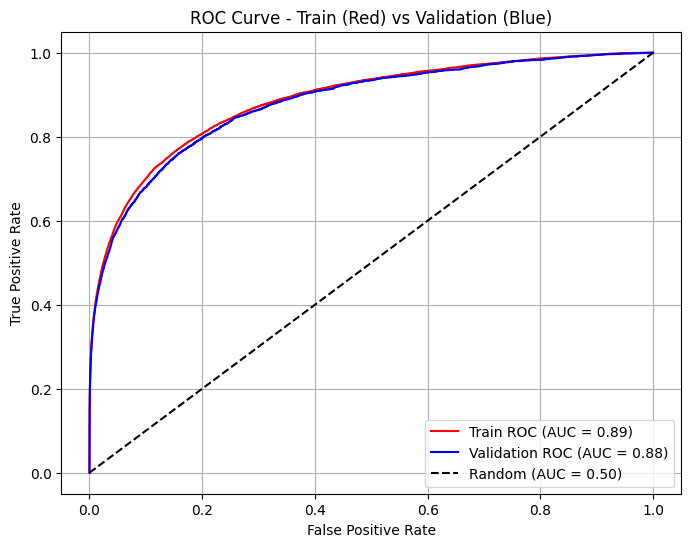

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_train_proba = lr_pipeline.predict_proba(X_train)[:, 1]
y_valid_proba = lr_pipeline.predict_proba(X_valid)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
auc_train = auc(fpr_train, tpr_train)
auc_valid = auc(fpr_valid, tpr_valid)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [32]:
!pip install dagshub 
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 52.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━

In [36]:
import dagshub
dagshub.init(repo_owner='lchik22', repo_name='ml_second_assignment', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=13e83d24-2faf-4b0b-a678-fd721232df43&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c51bba00ddb2e56a2246cf3c8e841ac0c574cdf5a849f21dafa4be822ca5c5d7




Accessing as lchik22

Initialized MLflow to track repo "lchik22/ml_second_assignment"

Repository lchik22/ml_second_assignment initialized!

In [37]:
import mlflow
mlflow.set_experiment("LogisticRegression_training")

2025/04/27 11:59:21 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression_training' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6963298ce06c4b459ff86c27b6e83fc6', creation_time=1745755161805, experiment_id='0', last_update_time=1745755161805, lifecycle_stage='active', name='LogisticRegression_training', tags={}>

Successfully registered model 'LogisticRegression'.
2025/04/27 12:22:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 1
Created version '1' of model 'LogisticRegression'.


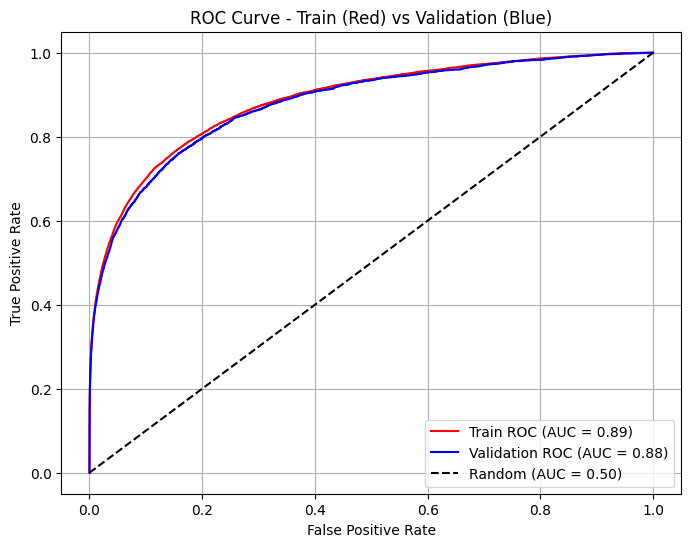

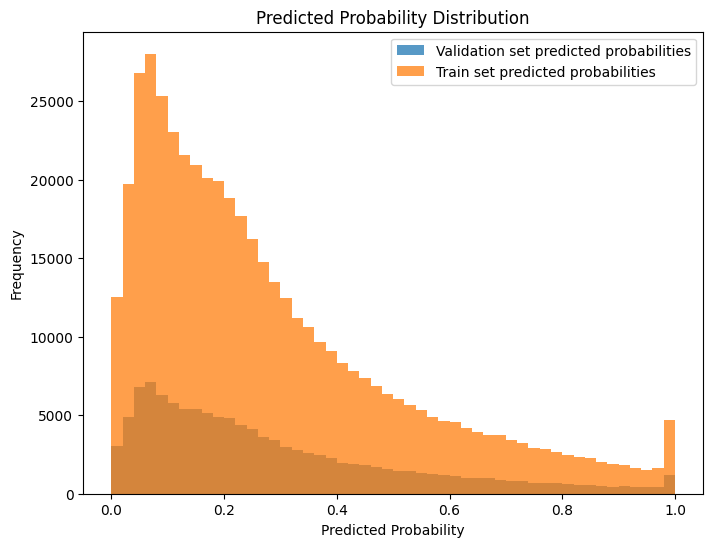

🏃 View run LogisticRegresion_Model at: https://dagshub.com/lchik22/ml_second_assignment.mlflow/#/experiments/0/runs/760fde95aed14aa3a6c6d6a7fbfee880
🧪 View experiment at: https://dagshub.com/lchik22/ml_second_assignment.mlflow/#/experiments/0


In [40]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import os
from mlflow.models.signature import infer_signature


with mlflow.start_run(run_name='LogisticRegresion_Model'):

    signature = infer_signature(X_train, y_train_proba)
    mlflow.sklearn.log_model(
        sk_model=lr_pipeline,
        artifact_path="logistic_regression",
        signature=signature,
        registered_model_name="LogisticRegression"
    )
    
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name='Important Parameters'):
    y_pred = lr_pipeline.predict(X_valid)

    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', rec)
    mlflow.log_metric('f1_score', f1)

🏃 View run Important Parameters at: https://dagshub.com/lchik22/ml_second_assignment.mlflow/#/experiments/0/runs/95a29aac794d4a5fb8e0c2a7cba22995
🧪 View experiment at: https://dagshub.com/lchik22/ml_second_assignment.mlflow/#/experiments/0
